In [1]:
%matplotlib inline

In [58]:
from matplotlib.cm import get_cmap
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [3]:
sns.set(style='white')

## Explorativní analýza

V této části budeme pracovat s poměrně podrobnými daty - přímo s programy (řešeními), které uživatelé v Robotanikovi vyplňují. Tyto programy Tutor ukládá ve chvíli, kdy uživatelé spustí své řešení.

Nejprve si ujasníme terminologii, která je důležitá k pochopení dat:
- Uživatel může řešit jednu úlohu vícekrát - jednomu pokusu řešení budeme říkat **hra (game)**.
- V rámci jedné hry uživatel postupně buduje program, který hýbe Robotanikem. Program může uživatel kdykoliv spustit. My v datech pracujeme pouze s programy z posledního spuštění v rámci jedné hry.

In [19]:
# Pomoci knihovny pandas nacteme data
programs = pd.read_csv('data/robotanik-programs.csv')

In [20]:
# Abychom ziskali predstavu, jak data vypadaji, muzeme si vypsat nekolik prvnich radku tabulky
programs.head()

,execution,game,max_recursion_depth,problem_id,problem_name,solved,time,user_id,visited
0,10,1,0,640,Schody,True,9,1,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
1,1,1,0,640,Schody,False,21,2,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
2,2,1,0,640,Schody,True,6,16387,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
3,2,1,1,640,Schody,True,2,5,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
4,3,1,0,640,Schody,True,3,6,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...


### Popis dat
| Sloupec             | Popis               |
|---------------------|---------------------|
| execution           | číslo označující, kolikátému spuštění v rámci jedné hry záznam odpovídá         |
| game                | číslo označájící, kolikáté hře záznam odpovídá |
| max_recursion_depth | maximální hloubka rekurze při spuštění programu |
| problem_id          | ID zadání |
| problem_name        | název zadání |
| solved              | správnost řešení |
| time                | počet sekund uplynulých od začátku řešení problému |
| user_id             | ID uživatele |
| visited             | souřadnice postupně navštívených polí (řádek, sloupec); hrací plán ma maximálně 12 řádků a 16 sloupců |

In [21]:
# souradnice navstivenych poli potrebujeme zpracovat,
# protoze aktualne je ve sloupci [visited] pouze retezec
programs['visited'] = programs['visited'].apply(
    lambda visited: [coord.split(':') for coord in visited.split('|')]
)

In [22]:
# rovnez se nam bude hodit si ulozit pocet kroku Robotanika
programs['steps'] = programs['visited'].apply(len)
# s casem se casto pracuje na logaritmicke skale
programs['time_log'] = programs['time'].apply(lambda x: 0 if x == 0 else np.log(x))

In [23]:
# nase data tedy vypadaji takto
programs.head()

,execution,game,max_recursion_depth,problem_id,problem_name,solved,time,user_id,visited,steps,time_log
0,10,1,0,640,Schody,True,9,1,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,2.197225
1,1,1,0,640,Schody,False,21,2,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,3.044522
2,2,1,0,640,Schody,True,6,16387,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,1.791759
3,2,1,1,640,Schody,True,2,5,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,0.693147
4,3,1,0,640,Schody,True,3,6,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,1.098612


In [24]:
# dale si pripravime data tykajici jednotlivych uloh
def _apply(group):
    correct = group[group['solved']]
    wrong = group[~group['solved']]
    return pd.DataFrame([{
        'success': group['solved'].mean(),
        'time_all': group['time'].median(),
        'time_correct': correct['time'].median(),
        'time_wrong': wrong['time'].median(),
        'users': len(group['user_id'].unique()),
        'executions_all': group['execution'].median(),
        'executions_correct': correct['execution'].median(),
        'executions_wrong': wrong['execution'].median(),
        'steps_all': group['steps'].mean(),
        'steps_correct': correct['steps'].mean(),
        'steps_wrong': wrong['steps'].mean(),
        'recursion_all': group['max_recursion_depth'].median(),
        'recursion_correct': correct['max_recursion_depth'].median(),
        'recursion_wrong': wrong['max_recursion_depth'].median(),
    }])
problems = programs.groupby(['problem_id', 'problem_name']).apply(_apply).reset_index()
problems.head()

,problem_id,problem_name,level_2,executions_all,executions_correct,executions_wrong,recursion_all,recursion_correct,recursion_wrong,steps_all,steps_correct,steps_wrong,success,time_all,time_correct,time_wrong,users
0,636,Trénink rekurze,0,2.0,2.0,1.0,0.0,0.0,0.0,6.348976,7.000000,2.942652,0.839545,1.0,1.0,12.0,7734
1,637,Trénink funkcí,0,3.0,3.0,3.0,0.0,1.0,0.0,15.122859,13.001168,18.396215,0.606734,2.0,1.0,17.0,5965
2,638,Trénink barev,0,3.0,3.0,2.0,0.0,0.0,0.0,8.320376,9.000000,7.550909,0.531000,5.0,2.0,14.0,6927
3,639,Cik cak,0,4.0,4.0,5.0,1.0,1.0,1.0,26.220096,29.000000,22.745215,0.555556,6.0,3.0,20.0,1489
4,640,Schody,0,3.0,3.0,3.0,0.0,0.0,0.0,19.355452,19.000000,19.980695,0.637551,6.0,5.0,16.0,6230


### 1. Úkol: Porovnání dvou úloh pomocí histogramu

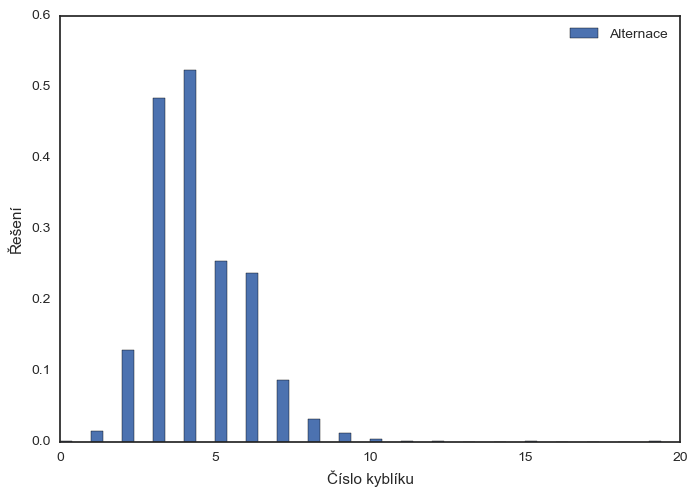

<function __main__.plot_histogram>

In [25]:
def plot_histogram(task1, task2, bin_count=20):
    # Histrogram se da zobrazit mnohem jednoduseji,
    # ale zde chceme porovnat dve ulohy v jednom grafu.
    
    # nejprve profiltrujeme data na pozadovane 2 ulohy
    data = programs[programs['problem_name'].isin({task1, task2})]
    # take je potreba se zbavit chybnych zaznamu
    data = data[data['time'] > 0]
    # pro kazdou ulohu si napocitame histogram,
    # a pak jej vykreslime
    for i, (task, task_data) in enumerate(data.groupby('problem_name')):
        # vypocet histogramu
        hist, bins = np.histogram(task_data['time_log'], bins=bin_count, normed=True)
        # vykresleni histogramu
        plt.bar(
            np.arange(0, len(hist)) + 0.4 * i,
            hist,
            width=0.4,
            color=sns.color_palette()[i * 2],
            label=task
        )
    plt.xlabel('Číslo kyblíku')
    plt.ylabel('Řešení')
    plt.legend(loc='upper right')
    plt.show()

# nasleduje kod, ktery vytvari interaktivni prvky
task1 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='První úloha:',
    disabled=False
)
task2 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Druhá úloha:',
    disabled=False
)
bin_count = widgets.IntSlider(value=20, min=5, max=50, description="Počet kyblíků")
widgets.interact(plot_histogram, task1=task1, task2=task2, bin_count=bin_count)

### 2. Úkol: Porovnání všech úloh pomocí scatter plotu

<function __main__.plot_scatter>

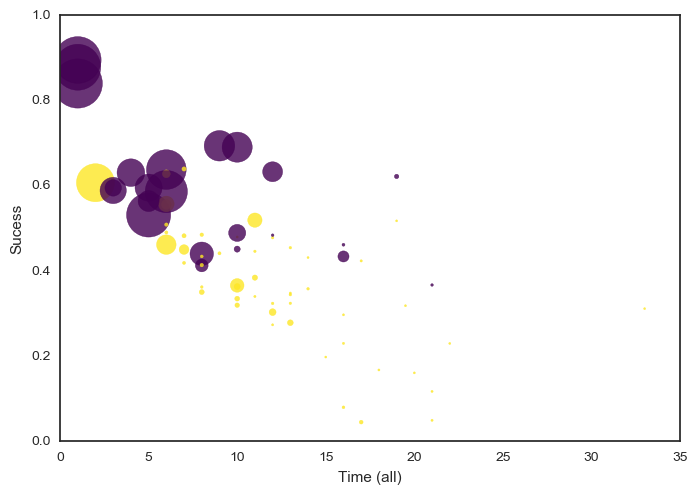

In [26]:
def plot_scatter(sample_size):
    data = problems[problems['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), sample_size))]
    size = 2 + np.pi * (20 * data['users'] / data['users'].max()) ** 2
    cmap = get_cmap('viridis')
    plt.scatter(data['time_all'], data['success'], s=size, color=cmap(data['recursion_correct']), alpha=0.8)
    plt.xlabel('Time (all)')
    plt.ylabel('Sucess')
    plt.ylim(0, 1)
    plt.xlim(0, plt.xlim()[1])
    
problem_count = len(programs['problem_id'].unique())
sample_size = widgets.IntSlider(min=10, max=problem_count, value=problem_count, description='Velikost vzorku')
widgets.interact(plot_scatter, sample_size=sample_size)

### 3. Úkol: Porovnání všech úloh pomocí pair gridu

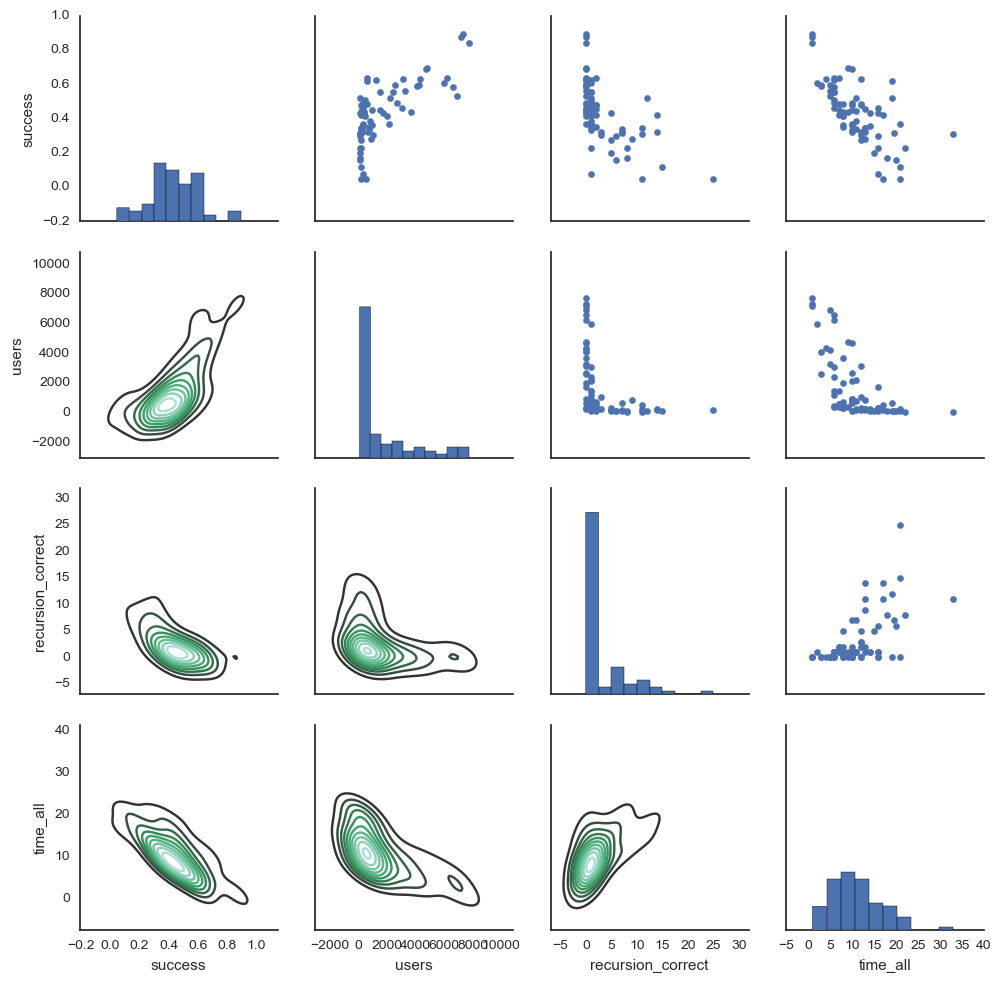

In [27]:
g = sns.PairGrid(problems[['success', 'users', 'recursion_correct', 'time_all']])
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

### 4. Úkol: Porovnání více úloh pomocí violinplotu

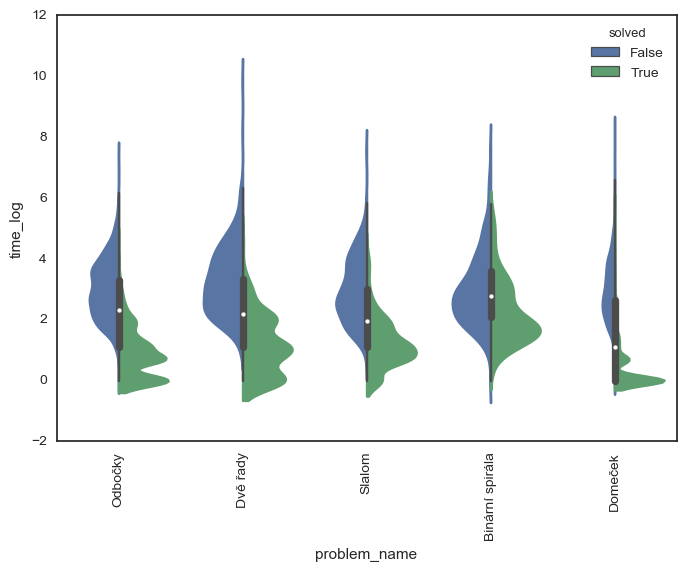

In [28]:
to_plot = programs[programs['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), 5))]
sns.violinplot(x='problem_name', y='time_log', hue='solved', split=True, data=to_plot)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 5. Úkol: Navštívená pole

/home/jpapouse/python-virtualenv/robotanik/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


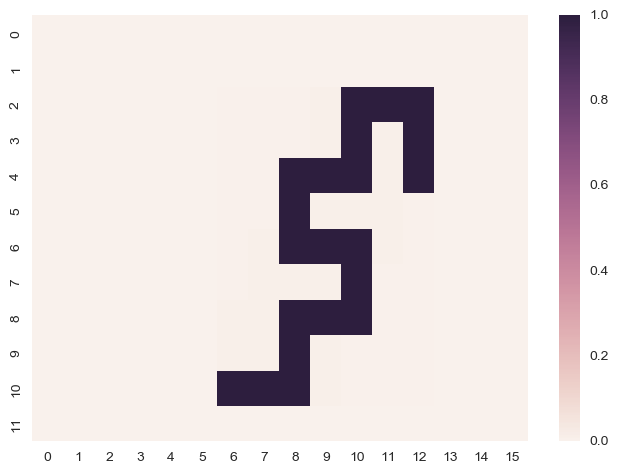

In [29]:
def plot_heatmap(task, correct=True):
    data = programs[programs['problem_name'] == task]
    data = data[data['solved'] == correct]
    visited_matrix = np.zeros((12, 16))
    for visited in data['visited'].values:
        for row, col in visited:
            visited_matrix[row, col] += 1
    sns.heatmap(visited_matrix / visited_matrix.max())

# nasleduje kod, ktery vytvari interaktivni prvky
task = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Úloha:',
    disabled=False
)
correct = widgets.Checkbox(description='Správná řešení')
widgets.interact(plot_heatmap, task=task, correct=correct)

## Strojové učení

Pokusíme se predikovat čas řešení úlohy na základě časů řešeních jiných úloh. Použijeme k tomu *lineární regresi*, což je jednoduchý model, který předpokládá lineární závislost mezi odhadovanou proměnnou a vstupními hodnotami. Mezi všem možnými linárními funkcemi zvolí tu, která minimalizuje průměrnou čtvercovou chybu, tj. průměr druhých mocnnin rozdílů mezi pozorovanými a predikovanými hodnotami.

Lineární regresi si napřed ukážeme na malém vzorku umělých dat.

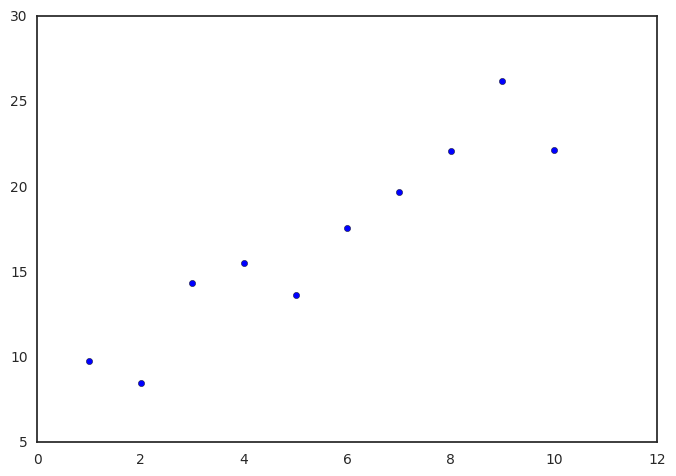

In [140]:
# Vygenrujeme si nahodna data
n = 10                               # n = pocet bodu
x = np.linspace(1, 10, num=n)        # x = 1, 2, ..., 10
noise = np.random.normal(0, 1.5, n)  # noise = normalni rozdeleni se stredem 0 a smerodatnou odchylkou 1.5
y = 5 + 2 * x + noise                # y = primka + sum
plt.scatter(x, y)

### Úkol: Nalezení nejlepší přímky

In [141]:
# TODO: pridat widget na rucni nastaveni primky + vypis MSE

### Knihovna scikit-learn

Knihovna `sklearn` nabízí model pro lineární regresi `linear_model.LinearRegression` s metodou `fit` pro naučení modelu ze zadaných dat. Pro výpočet čtvercové chyby pak lze použít funkci `mean_squared_error` z modulu `sklearn.metrics`.

Predicted line: y = 1.76 x + 7.27
Error = 3.384931583


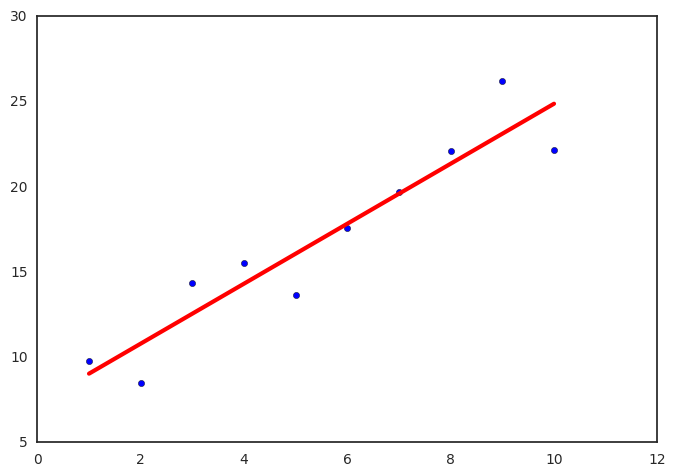

In [142]:
# Technikalie: potrebujeme matice n x 1 misto vektoru delky n
x = x.reshape(n, 1)
y = y.reshape(n, 1)

# Vytvorime a naucime linearni model
model = linear_model.LinearRegression()
model.fit(x, y)

# Koeficienty
print('Predicted line: y = {a:.2f} x + {b:.2f}'.format(a=model.coef_[0][0], b=model.intercept_[0]))

# Predikce
y_predictions = model.predict(x)
#print('Predictions:', y_predictions)

# Ctvercova chyba
print('Error =', mean_squared_error(y, y_predictions))

# Graf pozorovani vs. predikci
plt.scatter(x, y)
plt.plot(x, y_predictions, color='red', linewidth=3)

### Predikice času řešení

In [143]:
# Nacteme matici, ktera pro kazdou dvojici uzivatel-problem udava cas reseni
times = pd.read_csv('data/robotanik-user-problem-time.csv', index_col=0)

In [144]:
# Mame kolem 9000 uzivatelu (radky) a 80 uloh (sloupce)
times.shape

(9161, 78)

In [145]:
# Prvnich par radku matice vypada takto (NaN = "not a number" - uzivatel danou ulohu neresil/nevyresil)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
user_id,,,,,,,,,,,,,,,,,,,,,
1,25.0,13.0,14.0,38.0,NaN,459.0,NaN,NaN,NaN,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,5.0,49.0,19.0,92.0,23.0,57.0,40.0,42.0,211.0,...,NaN,NaN,NaN,NaN,NaN,NaN,185.0,113.0,36.0,73.0
4,26.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,52.0,39.0,25.0,19.0,364.0,25.0,99.0,NaN,56.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,68.0,20.0,32.0,18.0,NaN,42.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
# Budeme pracovat s logartimy casu
times = times.apply(np.log)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,...,NaN,NaN,NaN,NaN,NaN,NaN,5.220356,4.727388,3.583519,4.290459
4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# Omezime se na prvnich 11 uloh
times = times[[str(problem_id) for problem_id in range(635, 646)]]
times.head()

,635,636,637,638,639,640,641,642,643,644,645
user_id,,,,,,,,,,,
1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,NaN
2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,3.931826
4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,4.418841
6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,4.905275


In [148]:
# Vyfiltrujeme pouze ty resitele, kteri vyresili vsech 11 uloh
times = times.dropna()
times.head()

,635,636,637,638,639,640,641,642,643,644,645
user_id,,,,,,,,,,,
2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,3.931826
9,3.401197,2.564949,3.737670,3.828641,6.363028,4.330733,5.398163,5.476464,5.273000,4.343805,6.148468
11,3.988984,2.197225,3.178054,3.332205,4.454347,3.218876,6.556778,7.053586,4.204693,5.513429,4.430817
41,5.056246,2.079442,3.496508,2.833213,5.220356,3.828641,5.978886,6.293419,5.181784,4.304065,4.753590
44,5.298317,2.564949,3.433987,2.484907,4.521789,3.367296,3.637586,5.153292,5.123964,6.712956,4.934474


In [149]:
# Mame zhruba 300 studentu, kteri vsech techto 11 uloh vyresilo
times.shape

(322, 11)

### Úkol: 1D lineární regrese

Napřed si vyzkoušíme 1D lineární regresi jako v ukázce s umělými daty výše. Budeme predikovat čas řešení úlohy 645 (Alternace) z času řešení úlohy 639 (Cik cak)

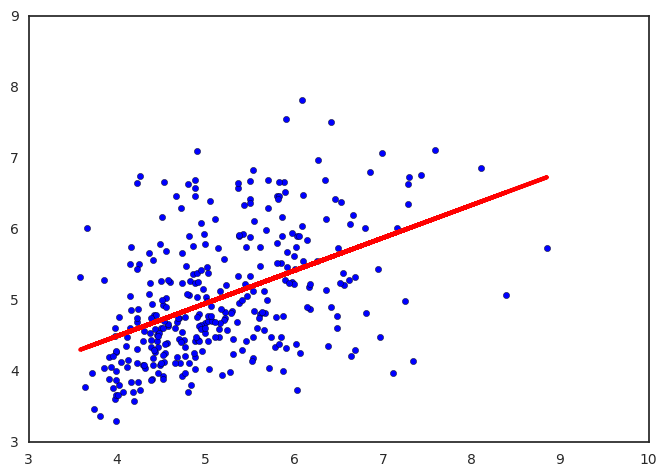

In [150]:
# Vytvorime matice potrebnych rozmeru (n x 1)
n = len(times)
x = times['639'].values.reshape(n, 1)
y = times['645'].values.reshape(n, 1)

# ----- UKOL: ------
# Natrenujeme linearni model
model = linear_model.LinearRegression()
model.fit(x, y)

# Vykreslime skutecne casy a predikce
plt.scatter(x, y),
y_predictions = model.predict(x)
plt.plot(x, y_predictions, linewidth=3, color='r')

In [151]:
# Spocitame ctvercovou chybu
# ----- UKOL -----
mean_squared_error(y, y_predictions)

0.62897967320934878

### Úkol: Vícedimenzionální lineární regrese

Teď budeme k predikci času 11. úlohy využívat časy prvních 10 úloh. Natrénujte lineární model a zjistěte, jestli takový model dosáhne menší čtvercové chyby.

In [153]:
# Budeme predikovat cas 11. ulohy z casu prvnich 10 uloh
m = 10

# Matice x ted bude mit rozmery n x m, y stale n x 1
x = times[[str(problem_id) for problem_id in range(635, 635+m)]].values.reshape(n, m)
y = times['645'].values.reshape(n, 1)

# ---- UKOL -----
# Natrenujeme linearni model
model = linear_model.LinearRegression()
model.fit(x, y)

# Vypocet predikci a vypis ctvercove chyby
y_predictions = model.predict(x)
mean_squared_error(y, y_predictions)
# ---------

0.4899739606529474

In [14]:
# TODO: diskuze podvodu (otazky)